Code based on the example at https://github.com/kach/gradient-descent-the-ultimate-optimizer

### Experiments with separate learning rates per layer/per parameter, and exponential link function.

Note : if you are using Colab, set COLAB=True at the end of the second cell, and run the following cell. Otherwise, simply don't run the next cell.

In [ ]:
!pip install gradient-descent-the-ultimate-optimizer

In [1]:
# IF AND ONLY IF YOU ARE USING COLAB, SET COLAB=True (at the end of this cell)
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from gradient_descent_the_ultimate_optimizer import gdtuo
COLAB=False

In [2]:
SAVEPATH='trainingdata/'
PREFIX='CIFAR10-' #Set to 'CIFAR10' for CIFAR10, '' for MNIST
if COLAB:
  from google.colab import drive
  SAVEPATH = '/content/drive/MyDrive/Colab Notebooks/' + SAVEPATH
  drive.mount('/content/drive/')

In [3]:
def save_training_data(train_loss, test_acc, test_loss, name):
  torch.save(train_loss, SAVEPATH+PREFIX+name+"-train-loss.pth")
  torch.save(test_acc, SAVEPATH+PREFIX+name+"-test-acc.pth")
  torch.save(test_loss, SAVEPATH+PREFIX+name+"-test-loss.pth")

def load_training_data(name):
  train_loss = torch.load(SAVEPATH+PREFIX+name+"-train-loss.pth")
  test_acc = torch.load(SAVEPATH+PREFIX+name+"-test-acc.pth")
  test_loss = torch.load(SAVEPATH+PREFIX+name+"-test-loss.pth")
  return train_loss, test_acc, test_loss

In [ ]:
#Code adapted from gdtuo implementation of SGD
class SGDExp(gdtuo.Optimizable):
    '''
    A hyperoptimizable SGD, with the option (if init with exp=True) to pass
    the learning rate through an exponential link function to ensure its positiveness
    and to make training more stable with regards to the "hyper-learning rate".

    Make sure to adapt the `alpha` value depending on whether you use this option.
    '''
    def __init__(self, alpha=0.01, mu=0.0, optimizer=gdtuo.NoOpOptimizer(), exp=False):
        self.mu = mu
        self.state = {}
        self.exp = exp
        parameters = {
            'alpha': torch.tensor(alpha),
            'mu': torch.tensor(mu)
        }
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if self.mu != 0.0:
                if name not in self.state:
                    buf = self.state[name] = g
                else:
                    buf = self.state[name].detach()
                    buf = buf * self.parameters['mu'] + g
                g = self.state[name] = buf
            if self.exp:
              params[name] = p - g * self.parameters['alpha'].exp()
            else:
              params[name] = p - g * self.parameters['alpha']

    def __str__(self):
        return 'sgd / '+ str(self.optimizer)

In [ ]:
#Have a different learning rate for each layer
class SGDLayerWise(gdtuo.Optimizable):
    '''
    Optimizes parameters with SGD using one learning rate per parameter tensor. 
    Note that the learning rate is shared between all elements of a given tensor.
    Furthermore, this class makes the alpha parameter go through an exponential link function.
    Thus the actual learning rate is exp(alpha). 

    TODO : rename lr0 to alpha0 because it is not the learning rate...
    '''
    def __init__(self, params, lr0=-1.0, optimizer=gdtuo.NoOpOptimizer(), device='cpu'):
        parameters = {k + '_alpha' : torch.tensor([lr0], requires_grad=True).to(device) for k, v in params}
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if name + '_alpha' not in self.parameters: params[name] = p
            else: params[name] = p - g * self.parameters[name + '_alpha'].exp()

    def __str__(self):
        return 'SGDLayerWise / ' + str(self.optimizer)

In [ ]:
class SGDParamWise(gdtuo.Optimizable):
    '''
    Optimizes parameters with SGD using one learning rate per parameter
    (effectively doubles the number of learnable parameters).

    Furthermore, this class makes the alpha parameter go through an exponential link function.
    Thus the actual learning rate is exp(alpha). 

    TODO : rename lr0 to alpha0 because it is not the learning rate...
    '''
    def __init__(self, params, lr0=-1.0, optimizer=gdtuo.NoOpOptimizer(), device='cpu'):
        parameters = {k + '_alpha' : lr0 * torch.ones_like(v).to(device)
                      for k, v in params}
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if name + '_alpha' not in self.parameters: params[name] = p
            else: params[name] = p - g * self.parameters[name + '_alpha'].exp()

    def __str__(self):
        return 'SGDLayerWise / ' + str(self.optimizer)

In [ ]:
##############################
## MNIST Model + Data
##############################

#Create the model and load the MNIST data. Don't execute this cell if you want to use CIFAR10 (run the next one instead).

class MNIST_FullyConnected(nn.Module):
    """
    A fully-connected NN for the MNIST task. This is Optimizable but not itself
    an optimizer.
    """
    def __init__(self, num_inp, num_hid, num_hid2, num_hid3, num_out):
        super(MNIST_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_hid2)
        self.layer3 = nn.Linear(num_hid2, num_hid3)
        self.layer4 = nn.Linear(num_hid3, num_out)


    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer3.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer4.weight, a=math.sqrt(5))

    def forward(self, x):
        """Compute a prediction."""
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.layer3(x)
        x = torch.tanh(x)
        x = self.layer4(x)
        x = F.log_softmax(x, dim=1)
        return x

BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 113832456.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29480577.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54549904.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5387592.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
##############################
## CIFAR10 Model + Data
##############################

#Create the model and load the MNIST data. Don't execute this cell if you want to use MNIST (run the previous one instead).

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.channels = channels

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    return y + x

class CIFAR10_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24)
    self.pooling1 = nn.MaxPool2d(2) #Nx24x16x16
    self.res2 = ResidualBlock(24)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)

#Load and transform data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

BATCH_SIZE = 256
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

100%|██████████| 170498071/170498071 [00:02<00:00, 79668104.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Test the model
def test(mw):
  with torch.no_grad():
      for features, labels in dl_test:
          if PREFIX=='': #MNIST
            features, labels = torch.reshape(features, (-1, 28 * 28)).to(DEVICE), labels.to(DEVICE)
          else: #CIFAR10
            features, labels = features.to(DEVICE), labels.to(DEVICE)
          pred = mw.forward(features)
          loss = F.nll_loss(pred, labels, reduction='sum')
          pred = torch.argmax(pred, dim=1)
          print("TEST ACCURACY: {}".format((pred == labels).sum().item() / len(labels)))
          break
  return (pred == labels).sum().item() / len(labels), loss / len(labels)

In [ ]:
#Training loop
def train(mw, record_data=False):
  #Store data about the training progress
  train_losses = []
  test_acc = []
  test_loss = []

  for i in range(1, EPOCHS+1):
      running_loss = 0.0
      for n, v in mw.optimizer.parameters.items():
          print(f"Learning rates : {n} : mean={v.mean().item()}, std={v.std().item()}, \
          min={v.min().item()}, max={v.max().item()}")
      for j, (features_, labels_) in enumerate(dl_train):
          mw.begin() # call this before each step, enables gradient tracking on desired params
          #features, labels = torch.reshape(features_, (-1, 28 * 28)).to(DEVICE), labels_.to(DEVICE)
          features, labels = features_.to(DEVICE), labels_.to(DEVICE)
          pred = mw.forward(features)
          loss = F.nll_loss(pred, labels)
          mw.zero_grad()
          loss.backward(create_graph=True) # important! use create_graph=True
          mw.step()

          running_loss += loss.item() * features_.size(0)
          if record_data:
            train_losses.append(loss.item())


      train_loss = running_loss / len(dl_train.dataset)

      print("EPOCH: {}, TRAIN LOSS: {}".format(i, train_loss))
      if record_data:
        acc, l = test(mw)
        test_acc.append(acc)
        test_loss.append(l.item())
  return train_losses, test_acc, test_loss

In [ ]:
#This is the baseline, with simple SGD (so no hyperoptimization).

#model_vanilla = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model_vanilla = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim_vanilla = gdtuo.SGD(alpha=math.exp(-2.0))
mw_vanilla = gdtuo.ModuleWrapper(model_vanilla, optimizer=optim_vanilla)
mw_vanilla.initialize()

train_loss, test_acc, test_loss = train(mw_vanilla, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGD")

Learning rates : alpha : mean=0.1353352814912796, std=nan,           min=0.1353352814912796, max=0.1353352814912796
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 1, TRAIN LOSS: 1.6644511247253417
TEST ACCURACY: 0.4453125
Learning rates : alpha : mean=0.1353352814912796, std=nan,           min=0.1353352814912796, max=0.1353352814912796
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 1.2759192936325072
TEST ACCURACY: 0.5859375
Learning rates : alpha : mean=0.1353352814912796, std=nan,           min=0.1353352814912796, max=0.1353352814912796
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 1.1048702878570558
TEST ACCURACY: 0.6484375
Learning rates : alpha : mean=0.1353352814912796, std=nan,           min=0.1353352814912796, max=0.1353352814912796
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 0.9875966917800904
TEST ACCURACY: 0.6953125


In [ ]:
#SGDExp-SGD algorithm, meaning hyperoptimization where the learning rate parameter goes through an exp.

#model_exp = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model_exp = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim_exp = SGDExp(alpha=-2.0, exp=True, optimizer=gdtuo.SGD(0.01))
mw_exp = gdtuo.ModuleWrapper(model_exp, optimizer=optim_exp)
mw_exp.initialize()

train_loss, test_acc, test_loss = train(mw_exp, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGDExp-SGD")

Learning rates : alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH: 1, TRAIN LOSS: 1.6426028886032105
TEST ACCURACY: 0.5390625
Learning rates : alpha : mean=-2.6400909423828125, std=nan,           min=-2.6400909423828125, max=-2.6400909423828125
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 1.2728037090682984
TEST ACCURACY: 0.6328125
Learning rates : alpha : mean=-3.0560302734375, std=nan,           min=-3.0560302734375, max=-3.0560302734375
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 1.1373739447021485
TEST ACCURACY: 0.6328125
Learning rates : alpha : mean=-3.3628859519958496, std=nan,           min=-3.3628859519958496, max=-3.3628859519958496
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 1.0457148471832276
TEST ACCURACY: 0.6796875
Learning rates : alpha : mean=-3.6173553466796875, std=nan,           min=-3.6173553466796875, max=-3.6173553466796875
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0

In [ ]:
#SGD-SGD optimizer, as described in Chandra et al's paper (https://arxiv.org/abs/1909.13371)

#model = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
#optim = gdtuo.SGD(alpha=0.1, optimizer=gdtuo.NoOpOptimizer())
optim = gdtuo.SGD(alpha=math.exp(-2.0), optimizer=gdtuo.SGD(0.0001))
mw = gdtuo.ModuleWrapper(model, optimizer=optim)
mw.initialize()

train_loss, test_acc, test_loss = train(mw, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGD-SGD")

Learning rates : alpha : mean=0.1353352814912796, std=nan,           min=0.1353352814912796, max=0.1353352814912796
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH: 1, TRAIN LOSS: 1.631498437576294
TEST ACCURACY: 0.5859375
Learning rates : alpha : mean=0.07293841987848282, std=nan,           min=0.07293841987848282, max=0.07293841987848282
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 1.233410507659912
TEST ACCURACY: 0.640625
Learning rates : alpha : mean=0.02075101248919964, std=nan,           min=0.02075101248919964, max=0.02075101248919964
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 1.1151973416900636
TEST ACCURACY: 0.65625
Learning rates : alpha : mean=0.006120017264038324, std=nan,           min=0.006120017264038324, max=0.006120017264038324
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 1.0809313529205322
TEST ACCURACY: 0.671875
Learning rates : alpha : mean=0.000899981358088553, std=nan,           min=0.000899981358088553, max=0.000899981358088553
Learning rates : mu : mean=0.0, std=nan,           min=0

In [ ]:
#SGDLW-SGD optimizer, meaning there is one separate learning rate per layer (or rather per parameter tensor).
#Also using the exponential link function for the learning rate.

#model2 = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model2 = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim2 = SGDLayerWise(model2.named_parameters(), -2.0, optimizer=gdtuo.SGD(0.01), device=DEVICE)
mw2 = gdtuo.ModuleWrapper(model2, optimizer=optim2)
mw2.initialize()

train_loss, test_acc, test_loss = train(mw2, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGDLW-SGD")

Learning rates : conv1.weight_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : conv1.bias_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res1.conv1.weight_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res1.conv1.bias_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res1.conv2.weight_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res1.conv2.bias_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res2.conv1.weight_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res2.conv1.bias_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res2.conv2.weight_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : res2.conv2.bias_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates : fc1.weight_alpha : mean=-2.0, std=nan,           min=-2.0, max=-2.0
Learning rates 

In [ ]:
#SGDPW-SGD optimizer, meaning there is one separate learning rate per parameter.
#Also using the exponential link function for the learning rate.

#model3 = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model3 = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim3 = SGDParamWise(model3.named_parameters(), -2.0, optimizer=gdtuo.SGD(0.01), device=DEVICE)
mw3 = gdtuo.ModuleWrapper(model3, optimizer=optim3)
mw3.initialize()

train_loss, test_acc, test_loss = train(mw3, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGDPW-SGD")

Learning rates : conv1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : conv1.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv1.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv2.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv2.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv1.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv2.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv2.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : fc1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates 

SGD-SGD 19550 50 50
SGDLW-SGD 19550 50 50
SGDExp-SGD 19550 50 50
SGD 19550 50 50
SGDPW-SGD 19550 50 50


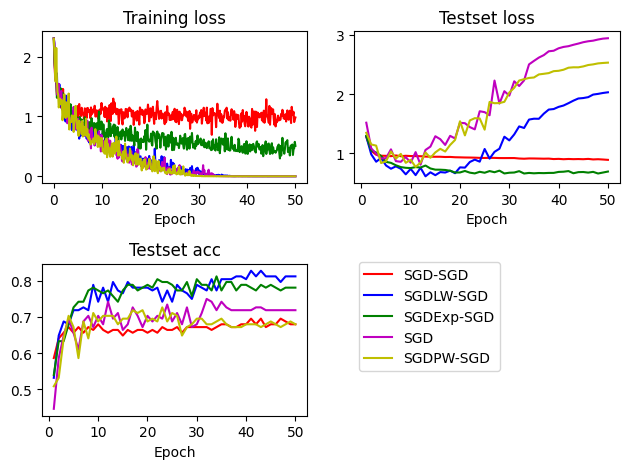

In [4]:
def plot_comparison(names):
  '''
  names : list of names
  '''
  colors = ['r', 'b', 'g', 'm', 'y', 'TOOMANYCOLORS']
  trlosses = []
  accs = []
  losses = []
  sample_freq = 50
  for n in names:
    t, a, l = load_training_data(n)
    trlosses.append(t[::sample_freq])
    accs.append(a)
    losses.append(l)
    print(n, len(t), len(a), len(l))


  fig, axs = plt.subplots(2, 2)
  trdata_x = torch.linspace(0, len(accs[0]), len(trlosses[0]))
  axs[0][0].set_title("Training loss")
  axs[0][1].set_title("Testset loss")
  axs[1][0].set_title("Testset acc")
  for n, t, a, l, c in zip(names, trlosses, accs, losses, colors):
    axs[0][0].plot(trdata_x, t, color=c, label=n)
    axs[0][1].plot(range(1, len(l)+1), l, color=c)
    axs[1][0].plot(range(1, len(a)+1), a, color=c)

  #axs[0][0].legend()
  #axs[1][1].set_visible(False)

  for ax in axs.flatten():
    ax.set_xlabel("Epoch")

  fig.delaxes(axs[1][1])
  fig.legend(loc='lower right', bbox_to_anchor=(0.8, 0.2))
  fig.tight_layout()
  plt.show()


plot_comparison(["SGD-SGD", "SGDLW-SGD", "SGDExp-SGD", "SGD", "SGDPW-SGD"])
